In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


from sklearn.metrics import roc_auc_score, roc_curve
import xgboost
import seaborn as sns
from geopy.distance import vincenty

In [2]:
import seaborn as sns

In [3]:
[f for f in os.listdir(os.curdir) if 'csv' in f]

['housing.csv', 'taxi.csv']

In [4]:
data_raw = pd.read_csv('taxi.csv')

### Эксплоративный анализ

In [5]:
data_raw.head(10)

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1
5,1058203,6,15,6080,360328,55.818963,37.361033,55.814827,37.354074,6.747,9.800,Economy,private,0
6,103326,2,11,6080,615584,55.753508,37.663742,55.757251,37.659064,-1.000,-1.000,Standard,business,1
7,128861,5,20,6080,254374,55.839318,37.248862,55.839134,37.304101,1.517,3.933,Economy,private,0
8,493006,5,20,6080,753429,55.818748,37.338240,55.835764,37.294710,6.222,15.433,Economy,private,0
9,953983,6,7,6080,533820,55.839155,37.251947,55.833198,37.312197,10.410,23.083,Economy,private,0


**offer_gk** – unique offer identifier (INT)<br>
**weekday_key** – day of week number (Sunday = 0, Monday = 1, etc.) (INT)<br>
**hour_key** – hour of day representing an hour part of datetime (value from 0 to 23) (INT)<br>
**driver_gk** – unique driver identifier (INT)<br>
**order_gk** – unique order identifier (INT). Order may have multiple offers<br>
**driver_latitude** – latitude of driver at the time of getting an offer (FLOAT)<br> 
**driver_longitude** – longitude of driver at the time of receiving an offer (FLOAT)<br>
**origin_order_latitude** – latitude of the order start location at the time of receiving an offer (FLOAT)<br>
**origin_order_longitude** – longitude of the order start location at the moment of receiving an offer (FLOAT)<br>
**distance_km** – estimated distance from origin to destination in kilometres (FLOAT). Value -1 means that the destination is not set<br>
**duration_min** – estimated duration from origin to destination in minutes (FLOAT). Value -1 means that the destination is not set<br>
**offer_class_group** – class of the order, e.g. Economy, Business, XL (VARCHAR)<br>
**ride_type_desc** – private or business order attribute (VARCHAR)<br>
**driver_response** – driver choice of whether to accept the offer or not (VARCHAR)<br>

In [6]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
offer_gk                  100000 non-null int64
weekday_key               100000 non-null int64
hour_key                  100000 non-null int64
driver_gk                 100000 non-null int64
order_gk                  100000 non-null int64
driver_latitude           100000 non-null float64
driver_longitude          100000 non-null float64
origin_order_latitude     100000 non-null float64
origin_order_longitude    100000 non-null float64
distance_km               100000 non-null float64
duration_min              100000 non-null float64
offer_class_group         100000 non-null object
ride_type_desc            100000 non-null object
driver_response           100000 non-null int64
dtypes: float64(6), int64(6), object(2)
memory usage: 10.7+ MB


In [7]:
data_raw['offer_class_group'].value_counts()

Economy     48335
Standard    47288
Premium      1773
Delivery     1290
Kids          588
XL            464
VIP           225
VIP+           29
Test            8
Name: offer_class_group, dtype: int64

In [8]:
group_share = pd.DataFrame(data_raw['offer_class_group'].value_counts(normalize=True, dropna=False)).reset_index()

In [9]:
group_share

,index,offer_class_group
0,Economy,0.48335
1,Standard,0.47288
2,Premium,0.01773
3,Delivery,0.01290
4,Kids,0.00588
5,XL,0.00464
6,VIP,0.00225
7,VIP+,0.00029
8,Test,0.00008


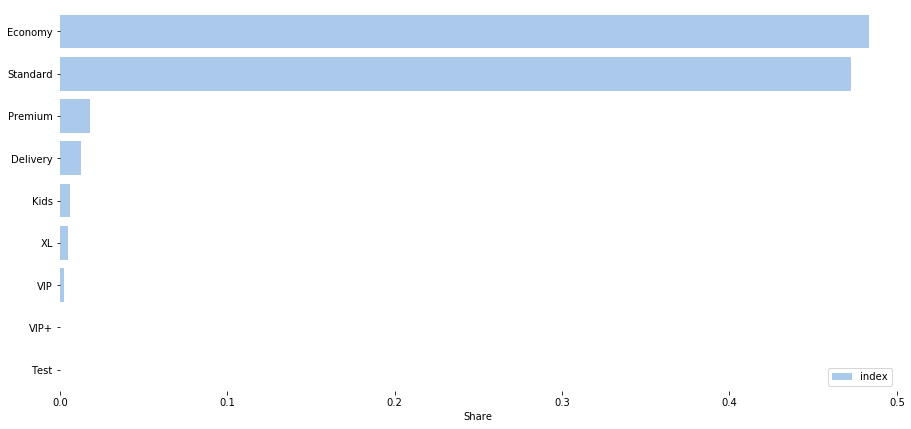

In [10]:
f, ax = plt.subplots(figsize=(15, 7))

sns.set_color_codes("pastel")
sns.barplot(x="offer_class_group",y="index", data=group_share,
            label="index", color="b")

ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(xlim=(0, 0.5), ylabel="",
       xlabel="Share")
sns.despine(left=True, bottom=True)

In [11]:
ax

In [12]:
data_raw[data_raw['driver_response'] == 1]['offer_class_group'].value_counts()

Standard    24755
Economy     21221
Premium      1368
Delivery      874
Kids          494
XL            330
VIP           174
VIP+           26
Test            6
Name: offer_class_group, dtype: int64

In [13]:
(
    data_raw[data_raw['driver_response'] == 1]['offer_class_group'].value_counts()
    /
    data_raw['offer_class_group'].value_counts()
)

Delivery    0.677519
Economy     0.439040
Kids        0.840136
Premium     0.771574
Standard    0.523494
Test        0.750000
VIP         0.773333
VIP+        0.896552
XL          0.711207
Name: offer_class_group, dtype: float64

### preprocessing and feature engineering

#### get one hot enc

In [14]:
def get_one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [15]:
cols_list = ['offer_class_group']
one_hot_df = get_one_hot(data_raw[['offer_class_group']], cols_list)

In [16]:
one_hot_df

,offer_class_group,offer_class_group_Delivery,offer_class_group_Economy,offer_class_group_Kids,offer_class_group_Premium,offer_class_group_Standard,offer_class_group_Test,offer_class_group_VIP,offer_class_group_VIP+,offer_class_group_XL
0,Economy,0,1,0,0,0,0,0,0,0
1,Standard,0,0,0,0,1,0,0,0,0
2,Economy,0,1,0,0,0,0,0,0,0
3,Economy,0,1,0,0,0,0,0,0,0
4,Economy,0,1,0,0,0,0,0,0,0
5,Economy,0,1,0,0,0,0,0,0,0
6,Standard,0,0,0,0,1,0,0,0,0
7,Economy,0,1,0,0,0,0,0,0,0
8,Economy,0,1,0,0,0,0,0,0,0
9,Economy,0,1,0,0,0,0,0,0,0


In [17]:
pd.get_dummies(data_raw[['offer_class_group']], prefix='1', drop_first=True).head(10)

,1_Economy,1_Kids,1_Premium,1_Standard,1_Test,1_VIP,1_VIP+,1_XL
0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0
7,1,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0


#### target encoding

In [18]:
def get_target_share(df_train, df_test, col, target_col):
    
    category_val_dict = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[col].value_counts()
    ).to_dict()
    
    
    df_train[col + '_counts'] = df_train[col].apply(category_val_dict.get)
    df_test[col + '_counts'] = df_test[col].apply(category_val_dict.get)
    return df_train, df_test

In [19]:
np.round((
    data_raw[data_raw['driver_response'] == 1]['offer_class_group'].value_counts()
    /
    data_raw['offer_class_group'].value_counts()
) * 100, 1)

Delivery    67.8
Economy     43.9
Kids        84.0
Premium     77.2
Standard    52.3
Test        75.0
VIP         77.3
VIP+        89.7
XL          71.1
Name: offer_class_group, dtype: float64

In [20]:
offer_class_group_dict = (
    data_raw[data_raw['driver_response'] == 1]['offer_class_group'].value_counts()
    /
    data_raw['offer_class_group'].value_counts()
).to_dict()

In [21]:
offer_class_group_dict

{'Delivery': 0.6775193798449612,
 'Economy': 0.4390400331023068,
 'Kids': 0.8401360544217688,
 'Premium': 0.7715736040609137,
 'Standard': 0.5234943326002368,
 'Test': 0.75,
 'VIP': 0.7733333333333333,
 'VIP+': 0.896551724137931,
 'XL': 0.7112068965517241}

In [22]:
offer_class_group_dict.get('Test', 21)

0.75

In [23]:
data_raw['offer_class_group']

0         Economy
1        Standard
2         Economy
3         Economy
4         Economy
5         Economy
6        Standard
7         Economy
8         Economy
9         Economy
10        Economy
11        Economy
12        Economy
13       Standard
14       Standard
15       Standard
16        Economy
17        Economy
18       Standard
19       Standard
20        Economy
21       Standard
22        Economy
23       Standard
24        Economy
25        Economy
26        Economy
27        Economy
28       Standard
29        Economy
           ...   
99970     Economy
99971     Economy
99972    Standard
99973    Standard
99974    Standard
99975     Economy
99976    Standard
99977    Standard
99978     Economy
99979    Standard
99980     Economy
99981    Standard
99982    Standard
99983     Economy
99984     Economy
99985     Economy
99986    Standard
99987    Standard
99988    Standard
99989     Economy
99990    Standard
99991    Standard
99992    Standard
99993    Standard
99994     

In [24]:
data_raw['offer_class_group'].apply(offer_class_group_dict.get).head(10)

0    0.439040
1    0.523494
2    0.439040
3    0.439040
4    0.439040
5    0.439040
6    0.523494
7    0.439040
8    0.439040
9    0.439040
Name: offer_class_group, dtype: float64

#### coordinates

In [25]:
data_raw[['origin_order_latitude', 'origin_order_longitude']].head(10)

,origin_order_latitude,origin_order_longitude
0,55.814567,37.355010
1,55.819329,37.466398
2,55.814827,37.354074
3,55.743469,37.431130
4,55.812559,37.527407
5,55.814827,37.354074
6,55.757251,37.659064
7,55.839134,37.304101
8,55.835764,37.294710
9,55.833198,37.312197


In [26]:
data_raw[['origin_order_latitude', 'origin_order_longitude']].apply(
    lambda x: str(round(x[0], 2)) + ' ' + str(round(x[1], 2)), axis=1
).value_counts().head(10)

55.96 37.41    21803
55.41 37.9      7585
55.97 37.42     3095
55.96 37.4      1047
55.61 37.29      996
55.75 37.54      852
55.76 37.62      840
55.76 37.61      777
55.77 37.59      588
55.78 37.59      577
dtype: int64

In [68]:
def get_woe_v1(df_train, df_test, col, target_col):
    all_good = len(df_train[df_train[target_col] == 1][col])
    all_bad = len(df_train[df_train[target_col] == 0][col])
    odds_series = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[df_train[target_col] == 0][col].value_counts()
    )
    odds_series = odds_series / all_good * all_bad
    category_woe_dict = np.log(odds_series).to_dict()
    df_train[col + '_woe'] = df_train[col].apply(category_woe_dict.get)
    df_test[col + '_woe'] = df_test[col].apply(category_woe_dict.get)
    return df_train, df_test

In [69]:
def get_woe_stat(df_train, col, target_col):
    stat = df_train.groupby(col)[target_col].agg(
        [np.mean, np.size, np.count_nonzero], sort=False
    )
    stat.rename(columns={'count_nonzero': 'good', 'size': 'obs', 'mean': 'event_rate'}, inplace=True)
    stat['all_good'] = stat['good'].sum()
    stat['p_good'] = stat['good'] / stat['all_good']
    stat['bad'] = stat['obs'] - stat['good']
    stat['all_bad'] = stat['bad'].sum()
    stat['p_bad'] = stat['bad'] / stat['all_bad']
    stat['WOE'] = np.log(stat['p_good'] / stat['p_bad'])
    stat['IV'] = ((stat['p_good'] - stat['p_bad']) * stat['WOE']).sum()
    stat['variable'] = col
    stat['category'] = stat.index
    stat.reset_index(inplace=True)
    stat.drop(labels=col, inplace=True, axis=1)
    return stat

In [70]:
test = get_woe_stat(data_raw, 'offer_class_group', 'driver_response')

In [71]:
test

,event_rate,obs,good,all_good,p_good,bad,all_bad,p_bad,WOE,IV,variable,category
0,0.677519,1290,874,49248,0.017747,416,50752,0.008197,0.772477,0.083468,offer_class_group,Delivery
1,0.439040,48335,21221,49248,0.430901,27114,50752,0.534245,-0.214977,0.083468,offer_class_group,Economy
2,0.840136,588,494,49248,0.010031,94,50752,0.001852,1.689323,0.083468,offer_class_group,Kids
3,0.771574,1773,1368,49248,0.027778,405,50752,0.007980,1.247300,0.083468,offer_class_group,Premium
4,0.523494,47288,24755,49248,0.502660,22533,50752,0.443983,0.124129,0.083468,offer_class_group,Standard
5,0.750000,8,6,49248,0.000122,2,50752,0.000039,1.128695,0.083468,offer_class_group,Test
6,0.773333,225,174,49248,0.003533,51,50752,0.001005,1.257312,0.083468,offer_class_group,VIP
7,0.896552,29,26,49248,0.000528,3,50752,0.000059,2.189567,0.083468,offer_class_group,VIP+
8,0.711207,464,330,49248,0.006701,134,50752,0.002640,0.931335,0.083468,offer_class_group,XL


In [72]:
# create categories based on the part of the day
def process_hour(hour):
    if 6 <= hour < 12:
        return 0
    elif 12 <= hour < 18:
        return 1
    elif 18 <= hour < 24:
        return 2
    elif 0 <= hour < 6:
        return 3

In [73]:
# create "is weekend?" feature
def process_day(day):
    if day <= 4:
        return 0
    else:
        return 1

In [74]:
# get vincenty distance between two points
def compute_dist_in_km(coords1, coords2):
    return vincenty(coords1, coords2).kilometers

In [75]:
# calculate ride cost based on the plan
def compute_taxi_cost(row):
    if row.offer_class_group == "Economy":
        return 97 + 7 * row.distance_km + 7 * row.duration_min
    elif row.offer_class_group == "Standard":
        return 150 + 11 * row.distance_km + 13 * row.duration_min
    elif row.offer_class_group == "Premium":
        return 299 + 15 * row.distance_km + 20 * row.duration_min
    elif row.offer_class_group == "Kids":
        return 99 + 22 * row.duration_min
    elif row.offer_class_group == "VIP":
        return 699 + 55 * row.distance_km + 25 * row.duration_min
    elif row.offer_class_group == "XL":
        return 299 + 15 * row.distance_km + 25 * row.duration_min
    else:
        return -1

In [76]:
airports_coordinates = [
    ("Domodedovo", (55.415832, 37.896903), 3), # Domodedovo
    ("Sheremetyevo", (55.972323, 37.412804), 3), # Sheremetyevo
    ("Vnukovo", (55.598791, 37.269157), 3), # Vnukovo
    ("Zhukovskiy", (55.561805, 38.118139), 3), # Zhukovskiy
    ("Moscow_center", (55.753742, 37.621852), 5), # center
]

In [77]:
# calculate distance from driver to airport and from origin to airport
def compute_airport_driver_dist(data):
    for airport, (air_latitude, air_longitude), radius in airports_coordinates:
        print(airport)

        dist_column_name = 'driver_dist_to_{}'.format(airport)
        radius_column_name = 'driver_near_to_{}'.format(airport)
        data[dist_column_name] = data.apply(
            lambda row: compute_dist_in_km(
                (row['driver_latitude'], row['driver_longitude'], (air_latitude, air_longitude))
            ),
            axis=1
        )
        data[radius_column_name] = data[dist_column_name].apply(lambda x: 1 if x <= radius else 0)
        # print(radius, len(dummies_df[dummies_df[radius_column_name] == 1]))


        dist_column_name = 'origin_order_dist_to_{}'.format(airport)
        radius_column_name = 'origin_order_near_to_{}'.format(airport)
        data[dist_column_name] = data.apply(
            lambda row: compute_dist_in_km(
                (row['origin_order_latitude'], row['origin_order_longitude']), (air_latitude, air_longitude)
            ),
            axis=1
        )
        data[radius_column_name] = data[dist_column_name].apply(lambda x: 1 if x <= radius else 0)
        # print(radius, len(dummies_df[dummies_df[radius_column_name] == 1]))
    return data

In [78]:
data_raw[['driver_latitude', 'driver_longitude']].apply(
    lambda x: str(np.round(x[0], 2)) + ' ' + str(np.round(x[1], 2)), axis=1
).value_counts(normalize=True)

55.96 37.41    0.21691
55.41 37.9     0.03317
55.96 37.42    0.03148
55.42 37.9     0.01891
55.97 37.42    0.01028
55.61 37.29    0.00846
55.76 37.61    0.00829
55.75 37.58    0.00696
55.77 37.62    0.00652
55.85 37.44    0.00646
55.77 37.59    0.00630
55.75 37.54    0.00625
55.76 37.6     0.00608
55.78 37.59    0.00591
55.77 37.6     0.00589
55.42 37.89    0.00585
55.77 37.61    0.00578
55.73 37.63    0.00502
55.75 37.61    0.00499
55.76 37.62    0.00474
55.45 37.86    0.00463
55.81 37.58    0.00462
55.75 37.57    0.00458
55.69 37.41    0.00440
55.43 37.88    0.00418
55.95 37.42    0.00413
55.75 37.6     0.00395
55.78 37.58    0.00387
55.76 37.56    0.00387
55.43 37.86    0.00381
                ...   
55.97 37.52    0.00001
55.95 37.44    0.00001
55.42 37.84    0.00001
55.48 37.71    0.00001
55.75 37.34    0.00001
55.56 37.71    0.00001
55.7 37.87     0.00001
55.63 37.46    0.00001
55.8 37.67     0.00001
55.6 37.97     0.00001
55.56 37.55    0.00001
55.65 38.1     0.00001
55.66 38.06

In [79]:
def build_new_columns(data):
    #создание пары координат
    origin_coordindates = data[['origin_order_latitude', 'origin_order_longitude']
    ].apply(lambda x: str(np.round(x[0], 2)) + ' ' + str(np.round(x[1], 2)), axis=1)
    
    driver_coordinates = data[['driver_latitude', 'driver_longitude']
    ].apply(lambda x: str(np.round(x[0], 2)) + ' ' + str(np.round(x[1], 2)), axis=1)
    
    data['origin_coordinates'] = origin_coordindates
    data['driver_coordinates'] = driver_coordinates
    
    
    #get one hot
    data = get_one_hot(
        data,
        ['offer_class_group', 'ride_type_desc', 'weekday_key', 'hour_key']
    )
    
    
    #часть дня - часть недели
    data['day_part'] = data.apply(lambda row: process_hour(row.hour_key), axis=1)
    data['week_part'] = data.apply(lambda row: process_day(row.hour_key), axis=1)
    
    data['driver_response_by_day_and_part'] = data[
        ['weekday_key', 'hour_key']
    ].apply(lambda x: str(x[0]) + '_' + str(x[1]), axis=1)

    #расстрояние грубо
    data['driver_to_offer_dist'] = data.apply(lambda row: compute_dist_in_km(
            (row.driver_latitude, row.driver_longitude),
            (row.origin_order_latitude, row.origin_order_longitude)
        ), axis=1)
    
    #цена поездки
    data['taxi_cost'] = data.apply(lambda row: compute_taxi_cost(row), axis=1)
    
    #не забываем удалить лишнее - мы их уже закодировали
    data = data.drop(
        labels=['offer_class_group', 'ride_type_desc', 'weekday_key', 'hour_key'],
        axis=1
    )
    
    
    data['duration_min_rounded'] = data['duration_min'].apply(lambda x: np.round(x, 0))
    
    data['is_address_submitted'] = data['duration_min'].apply(lambda x: x != -1)
    
    order_dict = data.order_gk.value_counts().to_dict()
    data['amount_of_offers'] = data['order_gk'].apply(order_dict.get)
    
    #средняя скорость по оценке приложения
    data['traffic'] = data[['distance_km', 'duration_min']].apply(
        lambda x: x[0] * 1. / x[1] if (x[1] != -1) and (x[0] != -1) else -1,
        axis=1
    )
    
    return data

In [39]:
data_raw.head(10)

,offer_gk,weekday_key,hour_key,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group,ride_type_desc,driver_response
0,1105373,5,20,6080,174182,55.818842,37.334562,55.814567,37.355010,-1.000,-1.000,Economy,private,0
1,759733,5,14,6080,358774,55.805342,37.515023,55.819329,37.466398,18.802,25.217,Standard,private,1
2,416977,6,14,6080,866260,55.813978,37.347688,55.814827,37.354074,6.747,9.800,Economy,private,0
3,889660,2,6,6080,163522,55.745922,37.421748,55.743469,37.431130,-1.000,-1.000,Economy,private,1
4,1120055,4,16,6080,506710,55.803578,37.521602,55.812559,37.527407,12.383,19.250,Economy,private,1
5,1058203,6,15,6080,360328,55.818963,37.361033,55.814827,37.354074,6.747,9.800,Economy,private,0
6,103326,2,11,6080,615584,55.753508,37.663742,55.757251,37.659064,-1.000,-1.000,Standard,business,1
7,128861,5,20,6080,254374,55.839318,37.248862,55.839134,37.304101,1.517,3.933,Economy,private,0
8,493006,5,20,6080,753429,55.818748,37.338240,55.835764,37.294710,6.222,15.433,Economy,private,0
9,953983,6,7,6080,533820,55.839155,37.251947,55.833198,37.312197,10.410,23.083,Economy,private,0


In [80]:
y = data_raw['driver_response'].copy()
#data_raw.drop(['driver_response'], inplace=True, axis=1)

In [81]:
from sklearn.model_selection import train_test_split
data_train, data_test, y_train, y_test = train_test_split(data_raw, y, test_size=0.3, random_state=42)

##### problem

In [82]:
len(list(filter(lambda x: x in data_train['driver_gk'], data_test['driver_gk'])))/len(list(data_test['driver_gk']))

0.6356333333333334

In [83]:
list(filter(lambda x: x in data_train['driver_gk'], data_test['driver_gk']))

[3719,
 3180,
 5006,
 517,
 5409,
 3823,
 975,
 1902,
 3261,
 2599,
 4759,
 1358,
 6080,
 1479,
 3180,
 3127,
 1421,
 4245,
 1358,
 6255,
 4490,
 5823,
 3633,
 3692,
 1421,
 4100,
 4652,
 3719,
 5187,
 1944,
 3926,
 1944,
 4490,
 1421,
 6302,
 6303,
 5441,
 6534,
 3670,
 2031,
 339,
 1989,
 5917,
 6506,
 3968,
 6800,
 3162,
 860,
 5242,
 2848,
 3400,
 2714,
 1316,
 4478,
 2433,
 235,
 3889,
 5917,
 4951,
 5753,
 3110,
 3526,
 6634,
 771,
 1495,
 3686,
 1358,
 4471,
 2599,
 1421,
 5714,
 259,
 566,
 1358,
 771,
 2472,
 5561,
 1537,
 4478,
 1421,
 2816,
 1305,
 1989,
 1421,
 3766,
 1421,
 1537,
 1421,
 6806,
 6195,
 6302,
 3277,
 3277,
 366,
 2487,
 3277,
 6732,
 3371,
 1537,
 4215,
 3371,
 6450,
 5420,
 6450,
 1421,
 860,
 3670,
 4600,
 6302,
 5148,
 1514,
 1537,
 4951,
 4865,
 4892,
 6806,
 3816,
 5967,
 5925,
 771,
 1944,
 3192,
 4490,
 4490,
 3763,
 5236,
 3110,
 1316,
 4754,
 3078,
 6732,
 5917,
 5242,
 3860,
 1944,
 6580,
 832,
 1266,
 3399,
 4471,
 1358,
 3162,
 5895,
 5437,
 6080

In [84]:
data_train = build_new_columns(data_train)
data_test = build_new_columns(data_test)

C:\Users\Edward\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Edward\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Edward\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, w

In [85]:
data_train

,offer_gk,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response,...,hour_key_23,day_part,week_part,driver_response_by_day_and_part,driver_to_offer_dist,taxi_cost,duration_min_rounded,is_address_submitted,amount_of_offers,traffic
76513,417053,6742,63249,55.756670,37.605210,55.741996,37.615415,11.573,31.767,1,...,0,3,0,6_3,1.754950,1107.935,32.0,True,1,0.364309
60406,122817,975,773813,55.961527,37.417454,55.966694,37.415754,41.589,40.750,0,...,0,2,1,5_19,0.585014,1137.229,41.0,True,4,1.020589
27322,249575,2381,635211,55.961857,37.414049,55.962322,37.407117,41.446,44.517,0,...,1,2,1,5_23,0.436015,698.741,45.0,True,3,0.931015
53699,471078,1420,6528,55.759718,37.572171,55.753287,37.584096,4.008,10.417,0,...,0,1,1,5_14,1.035968,197.975,10.0,True,1,0.384756
65412,610017,5561,224679,55.763485,37.559820,55.759126,37.548757,-1.000,-1.000,0,...,0,2,1,3_22,0.847269,126.000,-1.0,False,1,-1.000000
14297,1082589,2410,590522,55.755313,37.613295,55.706066,37.597452,7.251,14.517,0,...,0,3,0,1_3,5.572622,770.690,15.0,True,1,0.499483
15664,490634,422,839594,55.796050,37.378758,55.804749,37.329434,14.325,20.183,1,...,0,0,1,2_7,3.241385,569.954,20.0,True,1,0.709756
49235,723123,4951,111965,55.896235,37.389717,55.888916,37.393274,2.626,6.183,1,...,0,2,1,1_18,0.844739,158.663,6.0,True,1,0.424713
99277,115074,2442,505761,55.961260,37.413497,55.962322,37.407117,42.530,48.217,1,...,0,1,1,0_15,0.415633,1244.651,48.0,True,3,0.882054
13809,305273,6450,400534,55.847282,37.626522,55.852480,37.617671,7.973,20.950,0,...,0,2,1,1_21,0.801420,299.461,21.0,True,1,0.380573


In [86]:
#Преобразование категориальных
columns_to_get_counts = [
    'driver_gk',
    'origin_coordinates',
    'driver_coordinates',
    'driver_response_by_day_and_part',
    'duration_min_rounded',
]
    
for col_iter in columns_to_get_counts:
    data_train, data_test = get_woe_v1(data_train, data_test, col_iter, 'driver_response')

In [87]:
#Удаление лишних колонок
train_columns = [
    col for col in data_train.columns.tolist()
    if col not in set(
        [
            'offer_gk',
            'order_gk',
            'driver_response',
            'driver_gk',
            'origin_coordinates',
            'driver_coordinates',
            'driver_response_by_day_and_part',
#             'driver_response_by_day_and_part_counts',
            'duration_min_rounded',
        ]
    )
]
x_train = data_train[train_columns]
y_train = data_train['driver_response']
x_test = data_test[train_columns]
y_test = data_test['driver_response']

In [88]:
x_train.head()

,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group_Delivery,offer_class_group_Economy,offer_class_group_Kids,offer_class_group_Premium,...,driver_to_offer_dist,taxi_cost,is_address_submitted,amount_of_offers,traffic,driver_gk_woe,origin_coordinates_woe,driver_coordinates_woe,driver_response_by_day_and_part_woe,duration_min_rounded_woe
76513,55.756670,37.605210,55.741996,37.615415,11.573,31.767,0,0,0,1,...,1.754950,1107.935,True,1,0.364309,3.594220,1.069595,0.649180,-0.324425,0.020243
60406,55.961527,37.417454,55.966694,37.415754,41.589,40.750,0,0,0,0,...,0.585014,1137.229,True,4,1.020589,-2.828381,-2.197217,-1.786001,-0.227809,-0.662164
27322,55.961857,37.414049,55.962322,37.407117,41.446,44.517,0,1,0,0,...,0.436015,698.741,True,3,0.931015,-2.323509,-2.078743,-2.256283,-0.582805,-0.908378
53699,55.759718,37.572171,55.753287,37.584096,4.008,10.417,0,1,0,0,...,1.035968,197.975,True,1,0.384756,1.080740,1.287849,0.815473,0.637570,0.779347
65412,55.763485,37.559820,55.759126,37.548757,-1.000,-1.000,0,0,0,0,...,0.847269,126.000,False,1,-1.000000,-0.636712,0.960148,0.815333,-0.351194,0.227906


# Построение модели

In [89]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [90]:
#Создание модели
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)

#Обучение модели
xgb.fit(x_train, y_train)

#Предсказание модели на трейне
y_train_predict = xgb.predict_proba(x_train)[:, 1]
#Предсказание модели на тесте
y_test_predict = xgb.predict_proba(x_test)[:, 1]

#Рассчет roc_auc_score для трейна
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
#Рассчет roc_auc_score для теста
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)


print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.93
Test:  0.91


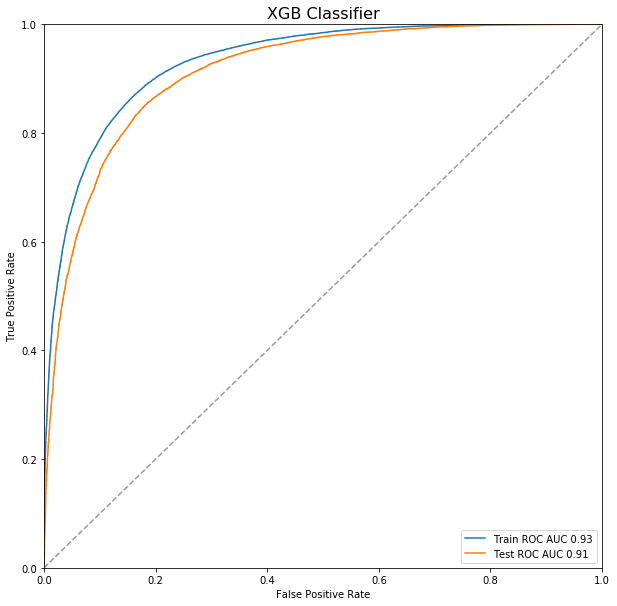

In [91]:
import matplotlib
#
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

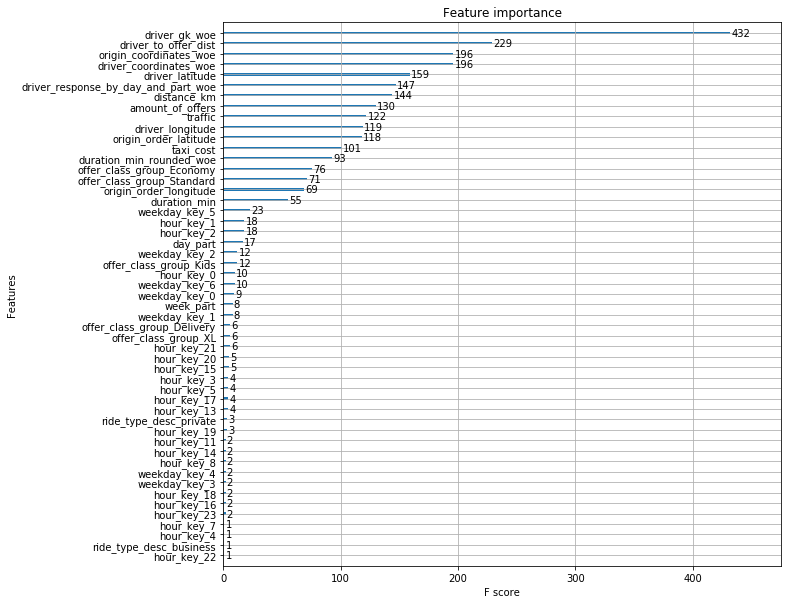

In [92]:
matplotlib.rcParams['figure.figsize'] = (10, 10)
xgboost.plot_importance(booster=xgb)
plt.savefig('tree_importance_test1.png')

# Прямой отбор переменных

In [93]:
x_train = x_train.transform(lambda x: x.fillna(0))
x_test = x_test.transform(lambda x: x.fillna(0))

In [94]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# custom_feature_names=feature_names

model = RandomForestClassifier(n_jobs=-1)


sfs_forward = SFS(model, 
           k_features=62, 
           forward=True, 
           floating=True, 
           verbose=1,
           scoring='roc_auc',
           cv=skf,
           n_jobs=-1)

sfs_forward = sfs_forward.fit(x_train.values, y_train.values,custom_feature_names=x_train.columns)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:  3.0min finished
Features: 1/62[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished
Features: 2/62[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.8s finished
Features: 3/62[Parallel(n_jobs=-1)]: Using backend 

Features: 19/62[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  43 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   43.9s finished
Features: 20/62[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   45.9s finished
Features: 21/62[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 out of  41 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   51.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent worker

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished
Features: 31/62[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:  1.5min finished
Features: 32/62[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished
[Parallel(n_jobs=

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  2.1min finished
Features: 36/62[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:  2.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.2min finished
Features: 36/62[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  26 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.3min finished
[Parallel(n_jobs=

Features: 46/62[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.1min finished
Features: 46/62[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 out of  46 | elapsed:  3.3min finished
Features: 47/62[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent worker

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:  4.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:  4.4min finished
Features: 57/62[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  57 out of  57 | elapsed:  4.5min finished
Features: 58/62[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   17.9s remaining:   17.9s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   19.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBac

AttributeError: 'tuple' object has no attribute 'set_size_inches'

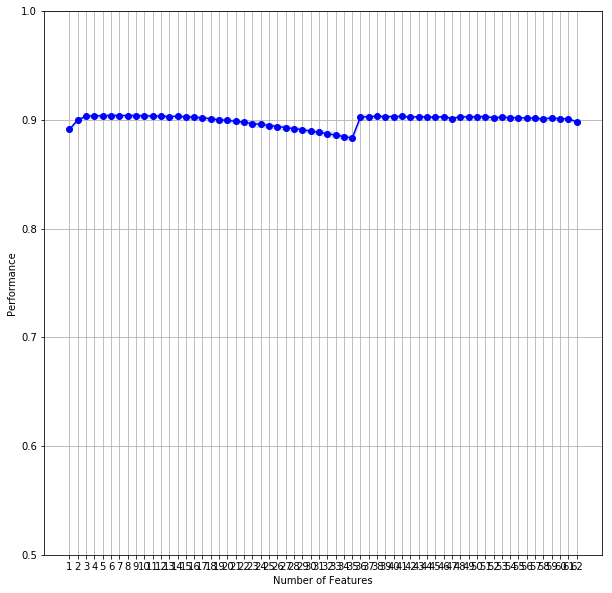

In [96]:
fig1 = plot_sfs(sfs_forward.get_metric_dict(), kind='std_dev')

plt.ylim([0.5, 1])
# plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
fig1.set_size_inches(12, 6)
plt.show()

In [97]:
sfs_forward.get_metric_dict()

{1: {'feature_idx': (57,),
  'cv_scores': array([0.8925701 , 0.89072314, 0.88971711, 0.89216511]),
  'avg_score': 0.8912938635314185,
  'feature_names': ('driver_gk_woe',),
  'ci_bound': 0.0018276304079055,
  'std_dev': 0.0011401445387931193,
  'std_err': 0.0006582627563872891},
 2: {'feature_idx': (10, 57),
  'cv_scores': array([0.90111872, 0.89898165, 0.8984862 , 0.90182197]),
  'avg_score': 0.9001021344169252,
  'feature_names': ('offer_class_group_Standard', 'driver_gk_woe'),
  'ci_bound': 0.002246751335599789,
  'std_dev': 0.0014016079258857997,
  'std_err': 0.0008092187133084796},
 3: {'feature_idx': (10, 55, 57),
  'cv_scores': array([0.90529426, 0.9028961 , 0.90111461, 0.90408045]),
  'avg_score': 0.9033463576413457,
  'feature_names': ('offer_class_group_Standard',
   'amount_of_offers',
   'driver_gk_woe'),
  'ci_bound': 0.0024725219757049765,
  'std_dev': 0.001542452136631207,
  'std_err': 0.0008905351562961408},
 4: {'feature_idx': (8, 10, 55, 57),
  'cv_scores': array([0.9

# Домашнее задание

Есть смысл кодировать one-hot только переменную driver_response_by_day_and_part для избежания некорректной размерности датасета, а также т.к. эта переменная сочетает в себе 2 переменных: день недели и время суток.

In [59]:
from sklearn.model_selection import train_test_split
data_train, data_test, y_train, y_test = train_test_split(data_raw, y, test_size=0.3, random_state=42)

In [99]:
data_train = build_new_columns(data_train)
data_test = build_new_columns(data_test)

KeyError: 'offer_class_group'

In [100]:
data_train.head()

,offer_gk,driver_gk,order_gk,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,driver_response,...,taxi_cost,duration_min_rounded,is_address_submitted,amount_of_offers,traffic,driver_gk_woe,origin_coordinates_woe,driver_coordinates_woe,driver_response_by_day_and_part_woe,duration_min_rounded_woe
76513,417053,6742,63249,55.756670,37.605210,55.741996,37.615415,11.573,31.767,1,...,1107.935,32.0,True,1,0.364309,3.594220,1.069595,0.649180,-0.324425,0.020243
60406,122817,975,773813,55.961527,37.417454,55.966694,37.415754,41.589,40.750,0,...,1137.229,41.0,True,4,1.020589,-2.828381,-2.197217,-1.786001,-0.227809,-0.662164
27322,249575,2381,635211,55.961857,37.414049,55.962322,37.407117,41.446,44.517,0,...,698.741,45.0,True,3,0.931015,-2.323509,-2.078743,-2.256283,-0.582805,-0.908378
53699,471078,1420,6528,55.759718,37.572171,55.753287,37.584096,4.008,10.417,0,...,197.975,10.0,True,1,0.384756,1.080740,1.287849,0.815473,0.637570,0.779347
65412,610017,5561,224679,55.763485,37.559820,55.759126,37.548757,-1.000,-1.000,0,...,126.000,-1.0,False,1,-1.000000,-0.636712,0.960148,0.815333,-0.351194,0.227906


In [101]:
#Преобразование категориальных
columns_to_get_counts = [
    'driver_response_by_day_and_part',
]

data_train_one_hot = get_one_hot(data_train, columns_to_get_counts)
data_test_one_hot = get_one_hot(data_test, columns_to_get_counts)

In [102]:
data_train_one_hot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 76513 to 15795
Columns: 238 entries, offer_gk to driver_response_by_day_and_part_6_9
dtypes: bool(1), float64(15), int64(7), object(3), uint8(212)
memory usage: 30.6+ MB


In [103]:
#Удаление лишних колонок
train_columns = [
    col for col in data_train_one_hot.columns.tolist()
    if col not in set(
        [
            'offer_gk',
            'order_gk',
            'driver_response',
            'driver_gk',
            'origin_coordinates',
            'driver_coordinates',
            'driver_response_by_day_and_part',
#             'driver_response_by_day_and_part_counts',
            'duration_min_rounded',
        ]
    )
]
x_train = data_train_one_hot[train_columns]
y_train = data_train_one_hot['driver_response']
x_test = data_test_one_hot[train_columns]
y_test = data_test_one_hot['driver_response']

In [104]:
x_train.head()

,driver_latitude,driver_longitude,origin_order_latitude,origin_order_longitude,distance_km,duration_min,offer_class_group_Delivery,offer_class_group_Economy,offer_class_group_Kids,offer_class_group_Premium,...,driver_response_by_day_and_part_6_21,driver_response_by_day_and_part_6_22,driver_response_by_day_and_part_6_23,driver_response_by_day_and_part_6_3,driver_response_by_day_and_part_6_4,driver_response_by_day_and_part_6_5,driver_response_by_day_and_part_6_6,driver_response_by_day_and_part_6_7,driver_response_by_day_and_part_6_8,driver_response_by_day_and_part_6_9
76513,55.756670,37.605210,55.741996,37.615415,11.573,31.767,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
60406,55.961527,37.417454,55.966694,37.415754,41.589,40.750,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27322,55.961857,37.414049,55.962322,37.407117,41.446,44.517,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
53699,55.759718,37.572171,55.753287,37.584096,4.008,10.417,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
65412,55.763485,37.559820,55.759126,37.548757,-1.000,-1.000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
#Создание модели
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)

#Обучение модели
xgb.fit(x_train, y_train)

#Предсказание модели на трейне
y_train_predict = xgb.predict_proba(x_train)[:, 1]
#Предсказание модели на тесте
y_test_predict = xgb.predict_proba(x_test)[:, 1]

#Рассчет roc_auc_score для трейна
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
#Рассчет roc_auc_score для теста
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)


print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.93
Test:  0.91


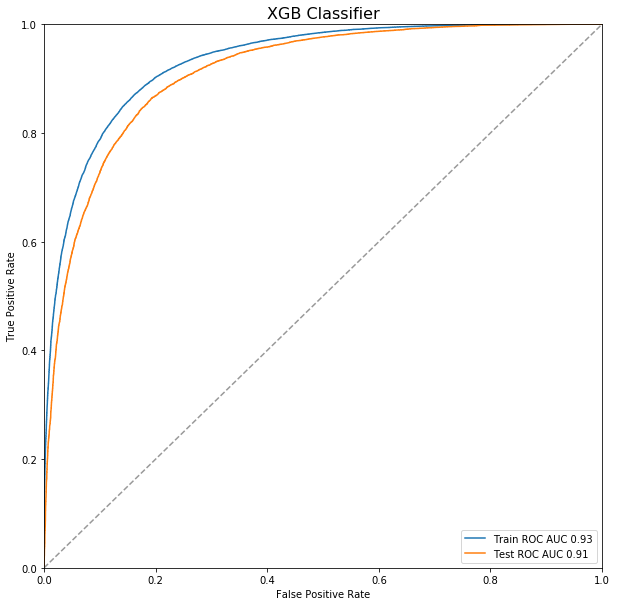

In [106]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

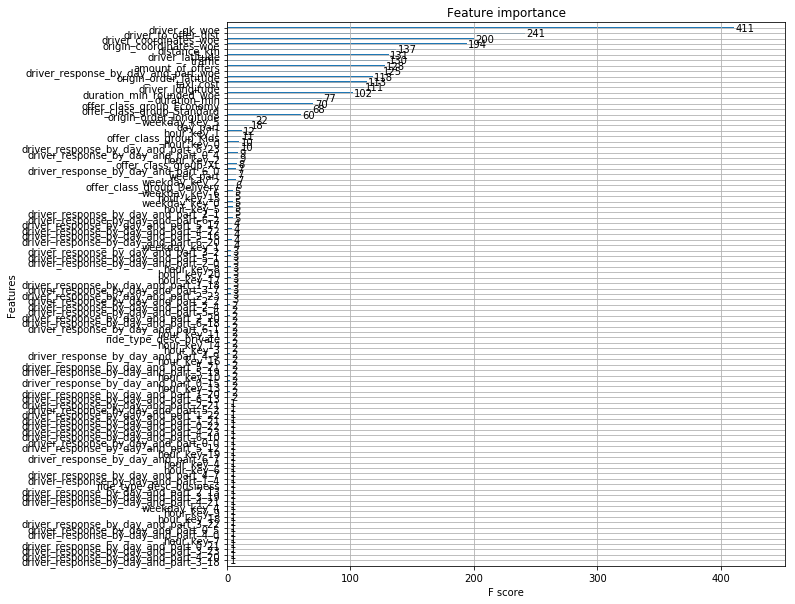

In [107]:
matplotlib.rcParams['figure.figsize'] = (10, 10)
xgboost.plot_importance(booster=xgb)

В результате имеем множество one-hot переменных, вносящих сами по себе незначительный вклад в точность модели. Корректнее кодировать one-hot небольшое число категориальных переменных с небольшим множеством принимаемых значений.

### get_target_share

In [109]:
import matplotlib
from sklearn.model_selection import train_test_split
data_train, data_test, y_train, y_test = train_test_split(data_raw, y, test_size=0.3, random_state=42)

In [110]:
data_train = build_new_columns(data_train)
data_test = build_new_columns(data_test)

C:\Users\Edward\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Edward\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Edward\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, w

In [ ]:
data_train.head()

In [111]:
#Преобразование категориальных
columns_to_get_counts = [
    'driver_gk',
    'origin_coordinates',
    'driver_coordinates',
    'driver_response_by_day_and_part',
    'duration_min_rounded',
]

for col_iter in columns_to_get_counts:
    data_train_target_share, data_test_target_share = get_target_share(data_train, data_test, col_iter, 'driver_response')

In [112]:
#Удаление лишних колонок
train_columns = [
    col for col in data_train_target_share.columns.tolist()
    if col not in set(
        [
            'offer_gk',
            'order_gk',
            'driver_response',
            'driver_gk',
            'origin_coordinates',
            'driver_coordinates',
            'driver_response_by_day_and_part',
#             'driver_response_by_day_and_part_counts',
            'duration_min_rounded',
        ]
    )
]
x_train = data_train_target_share[train_columns]
y_train = data_train_target_share['driver_response']
x_test = data_test_target_share[train_columns]
y_test = data_test_target_share['driver_response']

In [113]:
#Создание модели
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)

#Обучение модели
xgb.fit(x_train, y_train)

#Предсказание модели на трейне
y_train_predict = xgb.predict_proba(x_train)[:, 1]
#Предсказание модели на тесте
y_test_predict = xgb.predict_proba(x_test)[:, 1]

#Рассчет roc_auc_score для трейна
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
#Рассчет roc_auc_score для теста
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)


print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.93
Test:  0.9


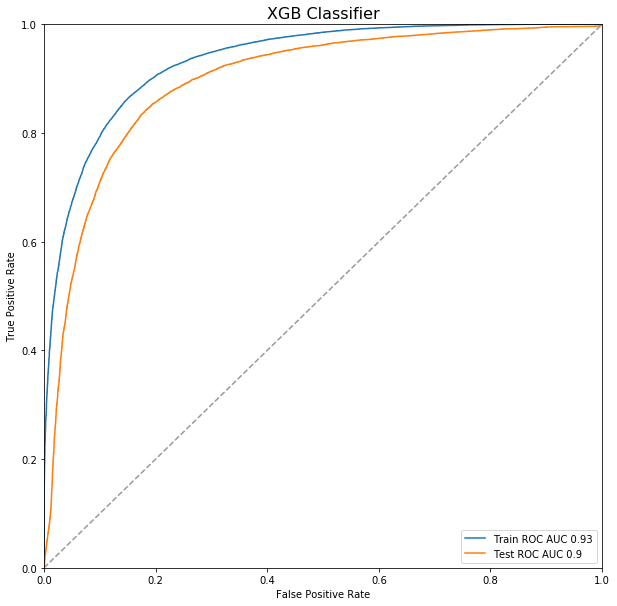

In [114]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

matplotlib.rcParams['figure.figsize'] = (10, 10)
xgboost.plot_importance(booster=xgb)

При вычислении доли таргета по сравнению с woe сгенерированные фичи имеют незначительно меньший F-score, что влияет на ACC модели.

### get_woe_v1

In [116]:
from sklearn.model_selection import train_test_split
data_train, data_test, y_train, y_test = train_test_split(data_raw, y, test_size=0.3, random_state=42)

In [117]:
data_train = build_new_columns(data_train)
data_test = build_new_columns(data_test)

C:\Users\Edward\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Edward\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Edward\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, w

In [ ]:
data_train.head()

In [118]:
#Преобразование категориальных
columns_to_get_counts = [
    'driver_gk',
    'origin_coordinates',
    'driver_coordinates',
    'driver_response_by_day_and_part',
    'duration_min_rounded',
]
    
for col_iter in columns_to_get_counts:
    data_train_woe_v1, data_test_woe_v1 = get_woe_v1(data_train, data_test, col_iter, 'driver_response')

In [119]:
#Удаление лишних колонок
train_columns = [
    col for col in data_train_woe_v1.columns.tolist()
    if col not in set(
        [
            'offer_gk',
            'order_gk',
            'driver_response',
            'driver_gk',
            'origin_coordinates',
            'driver_coordinates',
            'driver_response_by_day_and_part',
#             'driver_response_by_day_and_part_counts',
            'duration_min_rounded',
        ]
    )
]
x_train = data_train_woe_v1[train_columns]
y_train = data_train_woe_v1['driver_response']
x_test = data_test_woe_v1[train_columns]
y_test = data_test_woe_v1['driver_response']

In [120]:
#Создание модели
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)

#Обучение модели
xgb.fit(x_train, y_train)

#Предсказание модели на трейне
y_train_predict = xgb.predict_proba(x_train)[:, 1]
#Предсказание модели на тесте
y_test_predict = xgb.predict_proba(x_test)[:, 1]

#Рассчет roc_auc_score для трейна
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
#Рассчет roc_auc_score для теста
roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)


print("Train: ", roc_auc_train)
print("Test: ", roc_auc_test)

Train:  0.93
Test:  0.91


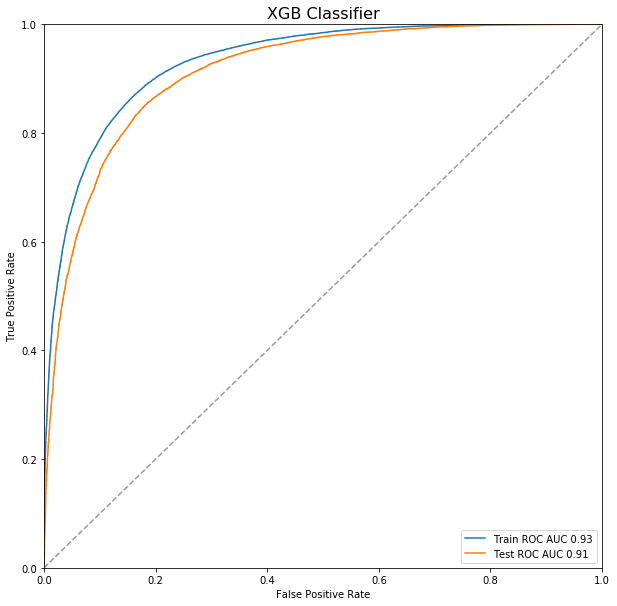

In [121]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

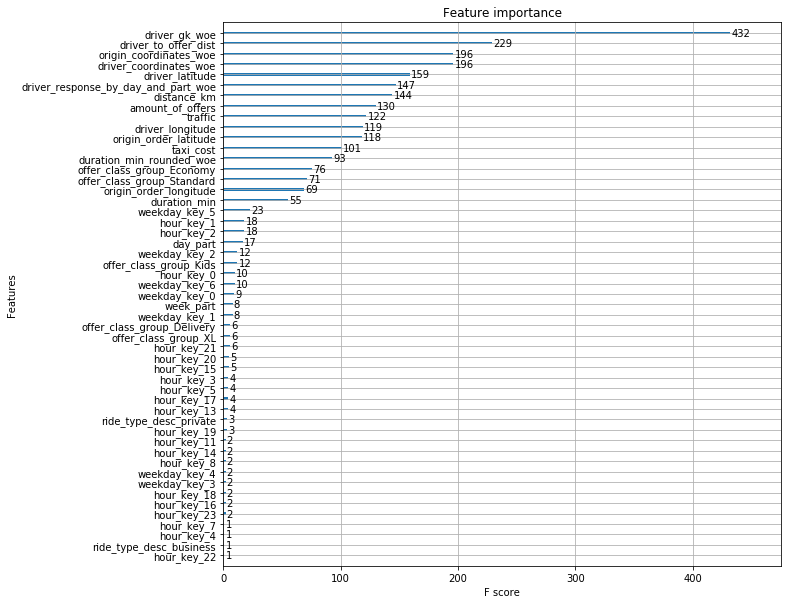

In [122]:
matplotlib.rcParams['figure.figsize'] = (10, 10)
xgboost.plot_importance(booster=xgb)